# GNN tutorial 2
> Node calssification with GNN (Cora dataset)

This tutorial will teach you how to apply Graph Neural Networks (GNNs) to the task of node classification. Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (transductive learning).

## Data

To demonstrate, we make use of the Cora dataset, which is a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them. The task is to infer the category of each document (7 in total).

This dataset was first introduced by Yang et al. (2016)^[Revisiting Semi-Supervised Learning with Graph Embeddings] as one of the datasets of the Planetoid benchmark suite. We again can make use PyTorch Geometric for an easy access to this dataset via `torch_geometric.datasets.Planetoid`^[https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid]:

In [1]:
import os
import torch

# helper function for visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F

/home/hankang07/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [4]:
data = dataset[0]  # Get the first graph object.
print()
print(data)
print('===========================================================================================================')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

- 각 클래스 당 20개씩 정답을 알고 있음.
- training node label rate = $5\%$ (학습을 위한 노드는 전체의 5% 밖에 안된다..)

*this network is undirected, and that there exists no isolated nodes (each document has at least one citation).*

## (시도1 ) Training a Multi-layer Perception Network(MLP)

n theory, we should be able to infer the category of a document solely based on its content, i.e. its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        ## 우리가 사용할 레이어 정의
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)
        ## 레이어 정의 끝!
        
    def forward(self, x):
        ## yhat을 어떻게 구할것인지 정의
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        ## 정의 끝!
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [9]:
model = MLP(hidden_channels=16)
loss_fn = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

In [10]:
data.test_mask.sum()

tensor(1000)

In [11]:
def train():
      model.train()
      optimizr.zero_grad()  # Clear gradients. <-- 앞에 나와도 상관없는건가??
      out = model(data.x)  # Perform a single forward pass.
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizr.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [12]:
# unseen labels에 대한 성능
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


In [13]:
1/7

0.14285714285714285

- MLP $\to$ $59\%$ test accuracy (그냥 찍는 것보다는 낫지만 성능이 별로임)

`-` ***문제1***
- 심각한 오버피팅때문에 성능이 안좋게 나오는 것.
- 그렇다면 왜 오버피팅이 될까? $\to$ 학습에 사용되는 training 노드수가 너무 작아 모르는 노드에 대해 일반화 하기 어렵다.

`-` ***문제2***
- MLP 모델은 중요한 bias가 반영이 안된다. (인용된 논문은 문서의 카테고리와 관련이 있을 가능성이 매우매우 높지만 이런것들이 반영이 안된다는 점)

***Graph Neural Network를 사용해서 모델 성능을 높일수 있을 것 같다.***

## (시도2) Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the torch.nn.Linear layers with PyG's GNN operators.

Following-up on the first part of this tutorial, we replace the linear layers by the GCNConv module. To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

- $\bf{W}^{l+1}$ : a trainable weight matrix of shape of shape [num_output_features, num_input_features]
- $c_{w,v}$: fixed normalization coefficient for each node.

in contrast, a single `Linear` layer is defined as

$$\bf{x}_v^{l+1} = \bf{W}^{l+1}\bf{x}_v^{l}$$


which does not make use of neighboring node information.

In [36]:
dataset.num_features, dataset.num_classes

(1433, 7)

In [37]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        ## 우리가 사용할 레이어 정의
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        ## 레이어 정의 끝!
        
    def forward(self, x, edge_index):
        ## yhat을 어떻게 구할것인지 정의
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        ## 정의 끝!
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### `-` 학습전 GCN network의 노드임베딩 시각화

we make use of [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

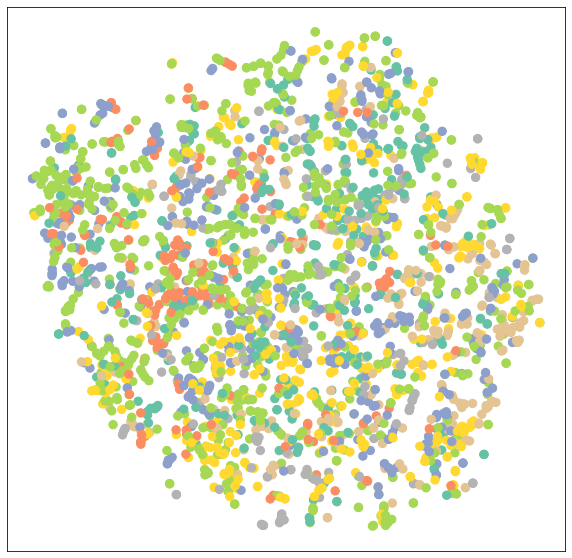

In [38]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model. The training and testing procedure is once again the same, but this time we make use of the node features `x` and the graph connectivity `edge_index` as input to our GCN model.

In [80]:
model = GCN(hidden_channels=16)
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizr.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizr.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

In [81]:
for epoch in range(1, 101):
    loss = train()
    test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9463, Test: 0.2700
Epoch: 002, Loss: 1.9409, Test: 0.2910
Epoch: 003, Loss: 1.9343, Test: 0.2910
Epoch: 004, Loss: 1.9275, Test: 0.3210
Epoch: 005, Loss: 1.9181, Test: 0.3630
Epoch: 006, Loss: 1.9086, Test: 0.4120
Epoch: 007, Loss: 1.9015, Test: 0.4010
Epoch: 008, Loss: 1.8933, Test: 0.4020
Epoch: 009, Loss: 1.8808, Test: 0.4180
Epoch: 010, Loss: 1.8685, Test: 0.4470
Epoch: 011, Loss: 1.8598, Test: 0.4680
Epoch: 012, Loss: 1.8482, Test: 0.5180
Epoch: 013, Loss: 1.8290, Test: 0.5440
Epoch: 014, Loss: 1.8233, Test: 0.5720
Epoch: 015, Loss: 1.8057, Test: 0.5910
Epoch: 016, Loss: 1.7966, Test: 0.6080
Epoch: 017, Loss: 1.7825, Test: 0.6300
Epoch: 018, Loss: 1.7617, Test: 0.6450
Epoch: 019, Loss: 1.7491, Test: 0.6520
Epoch: 020, Loss: 1.7310, Test: 0.6560
Epoch: 021, Loss: 1.7147, Test: 0.6570
Epoch: 022, Loss: 1.7056, Test: 0.6640
Epoch: 023, Loss: 1.6954, Test: 0.6770
Epoch: 024, Loss: 1.6697, Test: 0.6950
Epoch: 025, Loss: 1.6538, Test: 0.7140
Epoch: 026, Loss: 1.6312,

In [82]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


- GNN $\to 81.5\%$ test accuracy!!!

There it is! By simply swapping the linear layers with GNN layers, we can reach 81.5% of test accuracy! 

### `-` 학습후 GCN network의 노드임베딩 시각화

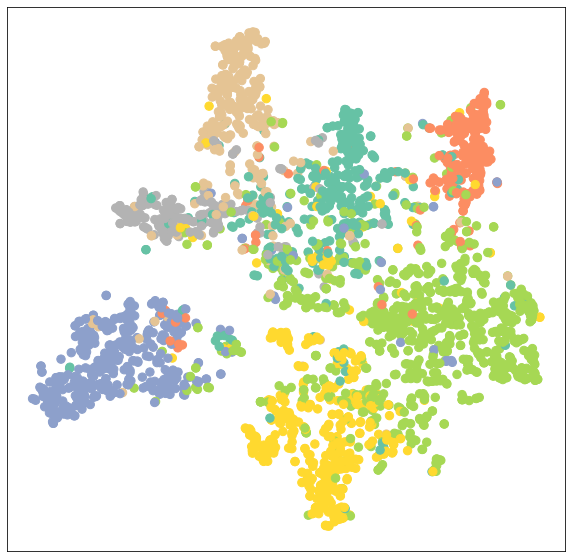

In [83]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

- 카테고리별로 군집이 어느정도 잘 나눠진 느낌

## (시도3) Validation set 이용 - 뭔가 잘못됨

In [111]:
model = GCN(hidden_channels=64)
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()


def val():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc

# 임지윤수정
# def test(mask):
#       model.eval()
#       out = model(data.x, data.edge_index)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
#       acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
#       return acc

In [112]:
for epoch in range(1, 101):
    loss = train()
    val_acc = val()
    test_acc = test()
    print(f'에폭: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

에폭: 001, Loss: 1.9461, Val: 0.2280, Test: 0.2530
에폭: 002, Loss: 1.9347, Val: 0.3720, Test: 0.3930
에폭: 003, Loss: 1.9207, Val: 0.6560, Test: 0.6540
에폭: 004, Loss: 1.9041, Val: 0.7480, Test: 0.7320
에폭: 005, Loss: 1.8870, Val: 0.7380, Test: 0.7490
에폭: 006, Loss: 1.8686, Val: 0.7600, Test: 0.7750
에폭: 007, Loss: 1.8476, Val: 0.7760, Test: 0.7890
에폭: 008, Loss: 1.8169, Val: 0.7800, Test: 0.7860
에폭: 009, Loss: 1.7975, Val: 0.7720, Test: 0.7830
에폭: 010, Loss: 1.7649, Val: 0.7700, Test: 0.7740
에폭: 011, Loss: 1.7330, Val: 0.7560, Test: 0.7750
에폭: 012, Loss: 1.7101, Val: 0.7640, Test: 0.7780
에폭: 013, Loss: 1.6784, Val: 0.7680, Test: 0.7790
에폭: 014, Loss: 1.6361, Val: 0.7720, Test: 0.7800
에폭: 015, Loss: 1.6086, Val: 0.7780, Test: 0.7840
에폭: 016, Loss: 1.5724, Val: 0.7820, Test: 0.7930
에폭: 017, Loss: 1.5306, Val: 0.7840, Test: 0.8000
에폭: 018, Loss: 1.4846, Val: 0.7900, Test: 0.8000
에폭: 019, Loss: 1.4324, Val: 0.8000, Test: 0.8030
에폭: 020, Loss: 1.4128, Val: 0.8020, Test: 0.8010
에폭: 021, Loss: 1.366

---

In [114]:
model = GCN(hidden_channels=256)
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
    loss = train()
    val_acc = val()
    test_acc = test()
    print(f'에폭: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

에폭: 001, Loss: 1.9448, Val: 0.2460, Test: 0.2360
에폭: 002, Loss: 1.9221, Val: 0.3020, Test: 0.3060
에폭: 003, Loss: 1.8922, Val: 0.3200, Test: 0.3270
에폭: 004, Loss: 1.8556, Val: 0.3940, Test: 0.4060
에폭: 005, Loss: 1.8123, Val: 0.4800, Test: 0.4960
에폭: 006, Loss: 1.7614, Val: 0.5400, Test: 0.5510
에폭: 007, Loss: 1.7012, Val: 0.5900, Test: 0.6140
에폭: 008, Loss: 1.6528, Val: 0.6440, Test: 0.6740
에폭: 009, Loss: 1.5808, Val: 0.6740, Test: 0.7130
에폭: 010, Loss: 1.5118, Val: 0.7080, Test: 0.7390
에폭: 011, Loss: 1.4335, Val: 0.7220, Test: 0.7500
에폭: 012, Loss: 1.3561, Val: 0.7400, Test: 0.7590
에폭: 013, Loss: 1.2777, Val: 0.7500, Test: 0.7660
에폭: 014, Loss: 1.2094, Val: 0.7560, Test: 0.7750
에폭: 015, Loss: 1.1225, Val: 0.7680, Test: 0.7820
에폭: 016, Loss: 1.0417, Val: 0.7720, Test: 0.7920
에폭: 017, Loss: 0.9676, Val: 0.7800, Test: 0.7990
에폭: 018, Loss: 0.9025, Val: 0.7900, Test: 0.8060
에폭: 019, Loss: 0.8258, Val: 0.7920, Test: 0.8100
에폭: 020, Loss: 0.7598, Val: 0.7940, Test: 0.8150
에폭: 021, Loss: 0.716

---

model A: filter = 64 
```
에폭: 097, Loss: 0.2554, Val: 0.7900, Test: 0.8090
에폭: 098, Loss: 0.2496, Val: 0.7920, Test: 0.8080
에폭: 099, Loss: 0.2493, Val: 0.7960, Test: 0.8100
에폭: 100, Loss: 0.2593, Val: 0.7960, Test: 0.8130
```

model B: flter = 256

```
에폭: 097, Loss: 0.1497, Val: 0.7880, Test: 0.8000
에폭: 098, Loss: 0.1559, Val: 0.7920, Test: 0.8020
에폭: 099, Loss: 0.1493, Val: 0.7940, Test: 0.8090
에폭: 100, Loss: 0.1488, Val: 0.8000, Test: 0.8090
```

train loss 기준: model B가 우수함

val loss 기준: model A가 우수함

실제test 데이터에 넣었을 경우: 모델 A가 우수함 

---

In [55]:
#test_acc = test(data.test_mask)
test_acc

0.813

In [56]:
#test(data.val_mask)

- 올라가야하는데 오히려 떨어졌는데?? (에폭수 늘려봐도 똑같다..)

## (시도4) hidden feature의 차원을 늘려보자.

### `-` hidden_channels = 32

In [35]:
model = GCN(hidden_channels=32)
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizr.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizr.step()  # Update parameters based on gradients.

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


In [145]:
model.eval()

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 7)
)

In [150]:
_out = model(data.x, data.edge_index)

In [151]:
_pred = _out.argmax(dim=1) 

In [153]:
(_pred[data.test_mask] == data.y[data.test_mask]).sum() / int(data.test_mask.sum())  #

tensor(0.0830)

In [154]:
data.test_mask.sum()

tensor(1000)

In [59]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'에폭: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

에폭: 001, Loss: 1.9455, Val: 0.2040, Test: 0.2490
에폭: 002, Loss: 1.9400, Val: 0.4880, Test: 0.4600
에폭: 003, Loss: 1.9309, Val: 0.4900, Test: 0.4740
에폭: 004, Loss: 1.9180, Val: 0.4220, Test: 0.4570
에폭: 005, Loss: 1.9058, Val: 0.3940, Test: 0.4240
에폭: 006, Loss: 1.8934, Val: 0.3840, Test: 0.4230
에폭: 007, Loss: 1.8779, Val: 0.4000, Test: 0.4390
에폭: 008, Loss: 1.8592, Val: 0.4200, Test: 0.4470
에폭: 009, Loss: 1.8494, Val: 0.4120, Test: 0.4300
에폭: 010, Loss: 1.8245, Val: 0.4220, Test: 0.4290
에폭: 011, Loss: 1.8075, Val: 0.4180, Test: 0.4250
에폭: 012, Loss: 1.7893, Val: 0.4440, Test: 0.4480
에폭: 013, Loss: 1.7692, Val: 0.4700, Test: 0.4770
에폭: 014, Loss: 1.7412, Val: 0.4940, Test: 0.4980
에폭: 015, Loss: 1.7192, Val: 0.5360, Test: 0.5290
에폭: 016, Loss: 1.6908, Val: 0.5800, Test: 0.5700
에폭: 017, Loss: 1.6828, Val: 0.6000, Test: 0.6080
에폭: 018, Loss: 1.6326, Val: 0.6220, Test: 0.6360
에폭: 019, Loss: 1.6089, Val: 0.6500, Test: 0.6640
에폭: 020, Loss: 1.5959, Val: 0.6840, Test: 0.6810
에폭: 021, Loss: 1.563

In [60]:
test_acc = test(data.test_mask)
test_acc

0.811

### `-` hidden_channels = 64

In [61]:
model = GCN(hidden_channels=64)
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizr.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizr.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

In [62]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'에폭: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

에폭: 001, Loss: 1.9461, Val: 0.2280, Test: 0.2530
에폭: 002, Loss: 1.9347, Val: 0.3720, Test: 0.3930
에폭: 003, Loss: 1.9207, Val: 0.6560, Test: 0.6540
에폭: 004, Loss: 1.9041, Val: 0.7480, Test: 0.7320
에폭: 005, Loss: 1.8870, Val: 0.7380, Test: 0.7490
에폭: 006, Loss: 1.8686, Val: 0.7600, Test: 0.7750
에폭: 007, Loss: 1.8476, Val: 0.7760, Test: 0.7890
에폭: 008, Loss: 1.8169, Val: 0.7800, Test: 0.7860
에폭: 009, Loss: 1.7975, Val: 0.7720, Test: 0.7830
에폭: 010, Loss: 1.7649, Val: 0.7700, Test: 0.7740
에폭: 011, Loss: 1.7330, Val: 0.7560, Test: 0.7750
에폭: 012, Loss: 1.7101, Val: 0.7640, Test: 0.7780
에폭: 013, Loss: 1.6784, Val: 0.7680, Test: 0.7790
에폭: 014, Loss: 1.6361, Val: 0.7720, Test: 0.7800
에폭: 015, Loss: 1.6086, Val: 0.7780, Test: 0.7840
에폭: 016, Loss: 1.5724, Val: 0.7820, Test: 0.7930
에폭: 017, Loss: 1.5306, Val: 0.7840, Test: 0.8000
에폭: 018, Loss: 1.4846, Val: 0.7900, Test: 0.8000
에폭: 019, Loss: 1.4324, Val: 0.8000, Test: 0.8030
에폭: 020, Loss: 1.4128, Val: 0.8020, Test: 0.8010
에폭: 021, Loss: 1.366

In [63]:
test_acc = test(data.test_mask)
test_acc

0.813

진짜 마지막

### `-` hidden_channels = 128

In [66]:
model = GCN(hidden_channels=128)
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizr.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizr.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

In [67]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'에폭: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

에폭: 001, Loss: 1.9459, Val: 0.2920, Test: 0.3330
에폭: 002, Loss: 1.9297, Val: 0.2880, Test: 0.3140
에폭: 003, Loss: 1.9134, Val: 0.3860, Test: 0.3930
에폭: 004, Loss: 1.8888, Val: 0.4760, Test: 0.4990
에폭: 005, Loss: 1.8626, Val: 0.5580, Test: 0.5820
에폭: 006, Loss: 1.8336, Val: 0.6280, Test: 0.6420
에폭: 007, Loss: 1.7979, Val: 0.6580, Test: 0.6730
에폭: 008, Loss: 1.7657, Val: 0.6700, Test: 0.6910
에폭: 009, Loss: 1.7229, Val: 0.6840, Test: 0.7180
에폭: 010, Loss: 1.6762, Val: 0.7000, Test: 0.7250
에폭: 011, Loss: 1.6376, Val: 0.7080, Test: 0.7370
에폭: 012, Loss: 1.5870, Val: 0.7300, Test: 0.7650
에폭: 013, Loss: 1.5326, Val: 0.7380, Test: 0.7740
에폭: 014, Loss: 1.4731, Val: 0.7520, Test: 0.7770
에폭: 015, Loss: 1.4370, Val: 0.7560, Test: 0.7840
에폭: 016, Loss: 1.3767, Val: 0.7660, Test: 0.7910
에폭: 017, Loss: 1.3069, Val: 0.7800, Test: 0.7910
에폭: 018, Loss: 1.2643, Val: 0.7820, Test: 0.8020
에폭: 019, Loss: 1.1892, Val: 0.7820, Test: 0.8040
에폭: 020, Loss: 1.1427, Val: 0.7860, Test: 0.8080
에폭: 021, Loss: 1.083

In [68]:
test_acc = test(data.test_mask)
test_acc

0.802

***실패: hidden channels=16일때가 제일 좋았다..*** 

## (시도5) 층을 더 쌓아보자.

In [79]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        ## 우리가 사용할 레이어 정의
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 32)
        self.conv3 = GCNConv(32, dataset.num_classes)
        ## 레이어 정의 끝!
        
    def forward(self, x, edge_index):
        ## yhat을 어떻게 구할것인지 정의
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv3(x, edge_index)
        ## 정의 끝!
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 7)
)


In [80]:
model = GCN(hidden_channels=16)  ## 다시 처음처럼
optimizr = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizr.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizr.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

In [81]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'에폭: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

에폭: 001, Loss: 1.9463, Val: 0.0600, Test: 0.0680
에폭: 002, Loss: 1.9436, Val: 0.0960, Test: 0.1230
에폭: 003, Loss: 1.9410, Val: 0.1840, Test: 0.1940
에폭: 004, Loss: 1.9393, Val: 0.1920, Test: 0.2000
에폭: 005, Loss: 1.9353, Val: 0.2100, Test: 0.2140
에폭: 006, Loss: 1.9314, Val: 0.2380, Test: 0.2490
에폭: 007, Loss: 1.9273, Val: 0.2720, Test: 0.2650
에폭: 008, Loss: 1.9238, Val: 0.2940, Test: 0.2740
에폭: 009, Loss: 1.9072, Val: 0.3440, Test: 0.3270
에폭: 010, Loss: 1.9020, Val: 0.4120, Test: 0.4070
에폭: 011, Loss: 1.8989, Val: 0.4620, Test: 0.4510
에폭: 012, Loss: 1.8787, Val: 0.5180, Test: 0.5020
에폭: 013, Loss: 1.8766, Val: 0.5260, Test: 0.5140
에폭: 014, Loss: 1.8677, Val: 0.4820, Test: 0.4820
에폭: 015, Loss: 1.8441, Val: 0.4420, Test: 0.4530
에폭: 016, Loss: 1.8193, Val: 0.4100, Test: 0.4130
에폭: 017, Loss: 1.8285, Val: 0.4140, Test: 0.4190
에폭: 018, Loss: 1.7950, Val: 0.4480, Test: 0.4840
에폭: 019, Loss: 1.7566, Val: 0.5000, Test: 0.5160
에폭: 020, Loss: 1.7496, Val: 0.5560, Test: 0.5420
에폭: 021, Loss: 1.709

In [83]:
test_acc = test(data.test_mask)
test_acc

0.777

층을 늘려봐도 test accuracy가 더 떨어진다.

## (시도6) GATConv layer 이용

`GCNConv` 인스턴스를 attention을 이용한 `GATConv`로 바꿔보자.

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(...)  # TODO
        self.conv2 = GATConv(...)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

- [관련논문](https://arxiv.org/pdf/1710.10903.pdf)^[GRAPH ATTENTION NETWORKS]

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance. In the next section, we will look into how GNNs can be used for the task of graph classification.